## Import Libraries and Dependencies

In [2]:
# Import our dependencies
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

import tensorflow as tf

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the data
file_path = Path("resources/processed_stroke_db_w_cat.csv")
df = pd.read_csv(file_path, index_col=[0])
print(df.shape)
df

(4909, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


## Process Data

### One-hot Encoding for Categotical Data & StandScaler for Numerical Data

In [4]:
# Generate categorical variable list
cat_labels= df.dtypes[df.dtypes == "object"].index.tolist()
print(cat_labels)

# Check the number of unique values in each column
print(df[cat_labels].nunique())

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64


In [5]:
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[cat_labels]))

encode_df.index = df.index

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_labels)
print(encode_df.shape)
encode_df.head()

(4909, 16)


,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
31112,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
60182,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1665,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
56669,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [6]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(cat_labels,1)
df.shape

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(4909, 22)

### Split, Oversample, Resample Data

In [7]:
# Split the preprocessed data into the features and target arrays
y = df["stroke"].values
X = df.drop(["stroke"],1).values

C:\Users\Kristen\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

In [9]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape

(3681, 21)

In [10]:
# Apply sampling technique to balance the minority class

# Option One: Resample the training data with SMOTE- Instantiate the model
# smote = SMOTE(random_state=1)


# Option Two: Resample the training data with ADASYN- Instantiate the model
smote = ADASYN(random_state=1)


# Resample the targets
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({0: 3524, 1: 3542})

## Single Perceptron Model

### Train, Fit, Evaluate, Predict Model

In [11]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=21))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 22        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
# Fit the model to the training data
fit_model = nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
221/221 [==============================] - 1s 3ms/step - loss: 0.7125 - accuracy: 0.5521 - val_loss: 0.7738 - val_accuracy: 0.6238
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.6465 - val_loss: 0.7282 - val_accuracy: 0.6653
Epoch 3/100
221/221 [==============================] - 0s 2ms/step - loss: 0.6196 - accuracy: 0.7157 - val_loss: 0.7019 - val_accuracy: 0.6743
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.7413 - val_loss: 0.6731 - val_accuracy: 0.7020
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5648 - accuracy: 0.7569 - val_loss: 0.6510 - val_accuracy: 0.7101
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5475 - accuracy: 0.7689 - val_loss: 0.6386 - val_accuracy: 0.7134
Epoch 7/100
221/221 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.7736 - val_loss: 0.6010 - val_accuracy: 0.7419

Epoch 58/100
221/221 [==============================] - 1s 2ms/step - loss: 0.4643 - accuracy: 0.7853 - val_loss: 0.4628 - val_accuracy: 0.7606
Epoch 59/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7846 - val_loss: 0.4635 - val_accuracy: 0.7614
Epoch 60/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7857 - val_loss: 0.4637 - val_accuracy: 0.7606
Epoch 61/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7855 - val_loss: 0.4628 - val_accuracy: 0.7606
Epoch 62/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.7845 - val_loss: 0.4626 - val_accuracy: 0.7598
Epoch 63/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7850 - val_loss: 0.4734 - val_accuracy: 0.7606
Epoch 64/100
221/221 [==============================] - 0s 2ms/step - loss: 0.4639 - accuracy: 0.7859 - val_loss: 0.4778 - val_accuracy:

In [14]:
# Create a DataFrame containing training history
nn_history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
nn_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.712513,0.552080,0.773757,0.623779
2,0.662378,0.646476,0.728191,0.665309
3,0.619571,0.715681,0.701865,0.674267
4,0.588262,0.741296,0.673136,0.701954
5,0.564809,0.756864,0.650995,0.710098
...,...,...,...,...
96,0.462748,0.784178,0.474634,0.758143
97,0.462854,0.785876,0.461020,0.761401
98,0.462923,0.784178,0.454403,0.761401
99,0.462893,0.785451,0.461273,0.760586


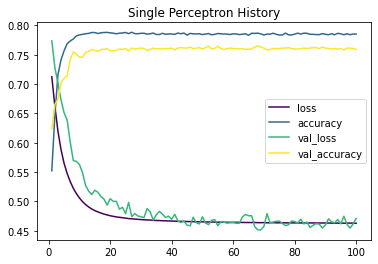

In [15]:
# Plot the history
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")

<AxesSubplot:>

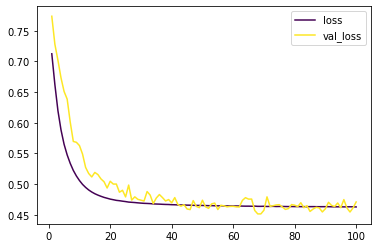

In [16]:
# Plot the loss
nn_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

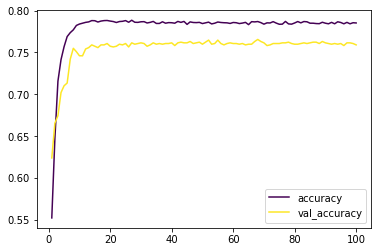

In [17]:
# Plot the accuracy
nn_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [18]:
# Evaluate the model using the test data
nn_model_loss,nn_model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the single perceptron model is: {nn_model_loss}, The accuracy is: {nn_model_accuracy}")

 The loss for the single perceptron model is: 0.4707680344581604, The accuracy is: 0.7589576840400696


In [19]:
# Y_pred: flatten & convert prediction probabilities to binary format so it can be passed through confusion matrix
y_pred_nn = nn_model.predict(X_test_scaled)
y_pred_nn = y_pred_nn.flatten()
y_pred_nn_tf=tf.round(y_pred_nn)

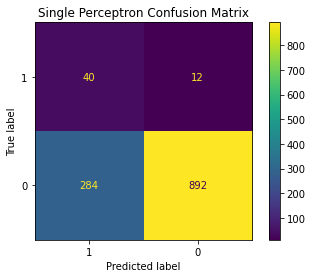

In [20]:
# Display the confusion matrix
nn_cm = confusion_matrix(y_test, y_pred_nn_tf, labels=[1,0])

nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=[1,0])
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")
nn_disp

In [21]:
# Advanced Classification Metrics
# Accuracy
nn_accuracy_score = accuracy_score(y_test, y_pred_nn_tf)
print(f'Accuracy Score of the Single Perceptron Model: {nn_accuracy_score}')

# Recall
nn_recall_score = recall_score(y_test, y_pred_nn_tf)
print(f'Recall Score of the Single Perceptron Model: {nn_recall_score}')

# Specificity
nn_specificity_score = 841 / 1176
print(f'Specifity Score of the Deep Learning Model: {nn_specificity_score}')

# Balanced Accuracy Score
nn_bas = balanced_accuracy_score(y_test, y_pred_nn_tf)
print(f'Balanced Accuracy Score of the Single Perceptron Model: {nn_bas}')

# Precision
nn_precision_score = precision_score(y_test, y_pred_nn_tf)
print(f'Precision Score of the Single Perceptron Model: {nn_precision_score}')     
   
# F1 Score
nn_f1_score = f1_score(y_test, y_pred_nn_tf)
print(f'F1 Score Score of the Single Perceptron Model: {nn_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {nn_model_loss}')

# Advanced Classification Metrics DF
nn_acm = {"Model Type": ["Single Perceptron"], "Accuracy":[nn_accuracy_score], "Recall": [nn_recall_score], "Specificity":[nn_specificity_score], 
          "Balanced Accuracy": [nn_bas], "Precision":[nn_precision_score], "F1 Score":[nn_f1_score], "Loss": [nn_model_loss]}
nn_acm_df = pd.DataFrame(data=nn_acm)
nn_acm_df

Accuracy Score of the Single Perceptron Model: 0.758957654723127
Recall Score of the Single Perceptron Model: 0.7692307692307693
Specifity Score of the Deep Learning Model: 0.7151360544217688
Balanced Accuracy Score of the Single Perceptron Model: 0.7638670852956567
Precision Score of the Single Perceptron Model: 0.12345679012345678
F1 Score Score of the Single Perceptron Model: 0.2127659574468085
Loss of the Multiple Perceptron Model: 0.4707680344581604


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.758958,0.769231,0.715136,0.763867,0.123457,0.212766,0.470768


## Multi-Perceptron Model

In [22]:
# Generate our new Sequential model
multi_nn_model = tf.keras.models.Sequential()

# Add the input and hidden layer
number_inputs = 21
number_hidden_nodes = 6

multi_nn_model.add(tf.keras.layers.Dense(units=number_hidden_nodes, activation="relu", input_dim=number_inputs))

# Add the output layer that uses a probability activation function
multi_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [23]:
# Compile the Sequential model together and customize metrics
multi_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
# Fit the model to the training data
fit_model_multi = multi_nn_model.fit(X_resampled, y_resampled, validation_data = (X_test_scaled, y_test), epochs=100, shuffle=True)

Epoch 1/100
221/221 [==============================] - 2s 4ms/step - loss: 0.6393 - accuracy: 0.6418 - val_loss: 0.4859 - val_accuracy: 0.7443
Epoch 2/100
221/221 [==============================] - 1s 3ms/step - loss: 0.5217 - accuracy: 0.7567 - val_loss: 0.4727 - val_accuracy: 0.7370
Epoch 3/100
221/221 [==============================] - 1s 3ms/step - loss: 0.4722 - accuracy: 0.7832 - val_loss: 0.4354 - val_accuracy: 0.7622
Epoch 4/100
221/221 [==============================] - 1s 4ms/step - loss: 0.4480 - accuracy: 0.8000 - val_loss: 0.4172 - val_accuracy: 0.7744
Epoch 5/100
221/221 [==============================] - 1s 3ms/step - loss: 0.4340 - accuracy: 0.8027 - val_loss: 0.4197 - val_accuracy: 0.7712
Epoch 6/100
221/221 [==============================] - 1s 3ms/step - loss: 0.4254 - accuracy: 0.8053 - val_loss: 0.4066 - val_accuracy: 0.7769
Epoch 7/100
221/221 [==============================] - 1s 3ms/step - loss: 0.4191 - accuracy: 0.8091 - val_loss: 0.4062 - val_accuracy: 0.7761

Epoch 58/100
221/221 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8409 - val_loss: 0.3956 - val_accuracy: 0.8037
Epoch 59/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3585 - accuracy: 0.8428 - val_loss: 0.3818 - val_accuracy: 0.8078
Epoch 60/100
221/221 [==============================] - 1s 5ms/step - loss: 0.3584 - accuracy: 0.8431 - val_loss: 0.3923 - val_accuracy: 0.8054
Epoch 61/100
221/221 [==============================] - 2s 7ms/step - loss: 0.3584 - accuracy: 0.8426 - val_loss: 0.3983 - val_accuracy: 0.8037
Epoch 62/100
221/221 [==============================] - 1s 4ms/step - loss: 0.3578 - accuracy: 0.8425 - val_loss: 0.3911 - val_accuracy: 0.8037
Epoch 63/100
221/221 [==============================] - 1s 5ms/step - loss: 0.3577 - accuracy: 0.8432 - val_loss: 0.3943 - val_accuracy: 0.8070
Epoch 64/100
221/221 [==============================] - 1s 5ms/step - loss: 0.3578 - accuracy: 0.8419 - val_loss: 0.3958 - val_accuracy:

In [25]:
# Create a DataFrame containing training history
multi_history_df = pd.DataFrame(fit_model_multi.history, index=range(1,len(fit_model_multi.history["loss"])+1))
multi_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.639291,0.641806,0.485948,0.744300
2,0.521726,0.756722,0.472654,0.736971
3,0.472202,0.783187,0.435381,0.762215
4,0.448044,0.800028,0.417209,0.774430
5,0.434006,0.802717,0.419746,0.771173
...,...,...,...,...
96,0.353807,0.842627,0.393465,0.805375
97,0.353505,0.842910,0.382758,0.807818
98,0.353480,0.845316,0.379939,0.814332
99,0.353320,0.844183,0.379562,0.813518


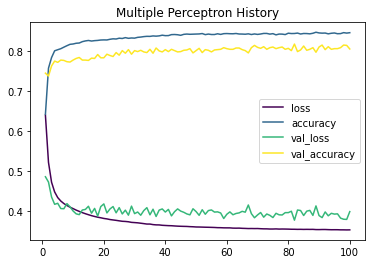

In [26]:
# Plot the history
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")

<AxesSubplot:>

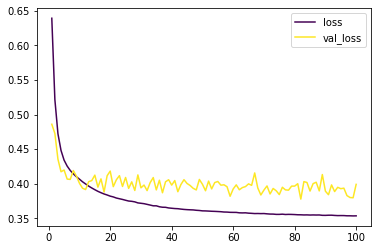

In [27]:
# Plot the loss
multi_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

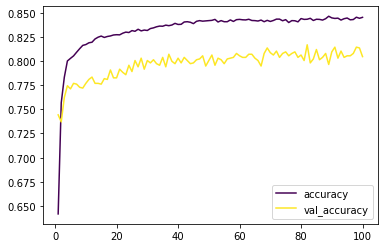

In [28]:
# Plot the accuracy
multi_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [29]:
# Evaluate the model using the test data
multi_model_loss, multi_model_accuracy = multi_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the multiple perceptron model is: {multi_model_loss}, The accuracy is: {multi_model_accuracy}")

 The loss for the multiple perceptron model is: 0.3989649713039398, The accuracy is: 0.8045602440834045


In [30]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_multi = multi_nn_model.predict(X_test_scaled)
y_pred_multi = y_pred_multi.flatten()
y_pred_multi_tf = tf.round(y_pred_multi)

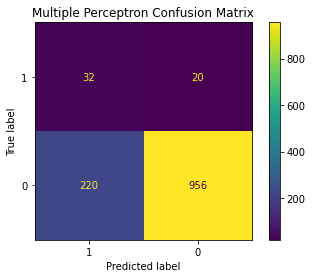

In [31]:
# Display the confusion matrix
multi_nn_cm = confusion_matrix(y_test, y_pred_multi_tf, labels=[1,0])

multi_disp = ConfusionMatrixDisplay(confusion_matrix=multi_nn_cm, display_labels=[1,0])
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")
multi_disp

In [32]:
# Advanced Classification Metrics
# Accuracy
multi_accuracy_score = accuracy_score(y_test, y_pred_multi_tf)
print(f'Accuracy Score of the Multiple Perceptron Model: {multi_accuracy_score}')

# Recall/ Sensitivity
multi_recall_score = recall_score(y_test, y_pred_multi_tf)
print(f'Recall Score of the Multiple Perceptron Model: {multi_recall_score}')

# Specificity
multi_specificity_score = 950 / 1176
print(f'Specifity Score of the Deep Learning Model: {multi_specificity_score}')

# Balanced Accuracy Score
multi_bas = balanced_accuracy_score(y_test, y_pred_multi_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {multi_bas}')

# Precision
multi_precision_score = precision_score(y_test, y_pred_multi_tf)
print(f'Precision Score of the Multiple Perceptron Model: {multi_precision_score}')     
      
# F1 Score
multi_f1_score = f1_score(y_test, y_pred_multi_tf)
print(f'F1 Score Score of the Multiple Perceptron Model: {multi_f1_score}')

# Loss Score
print(f'Loss of the Multiple Perceptron Model: {multi_model_loss}')

# Advanced Classification Metrics DF
multi_acm = {"Model Type": ["Multi Perceptron"], "Accuracy":[multi_accuracy_score], "Recall": [multi_recall_score], "Specificity":[multi_specificity_score], 
          "Balanced Accuracy": [multi_bas], "Precision":[multi_precision_score], "F1 Score":[multi_f1_score], "Loss": [multi_model_loss]}
multi_acm_df = pd.DataFrame(data=multi_acm)
multi_acm_df

Accuracy Score of the Multiple Perceptron Model: 0.8045602605863192
Recall Score of the Multiple Perceptron Model: 0.6153846153846154
Specifity Score of the Deep Learning Model: 0.8078231292517006
Balanced Accuracy Score of the Multiple Perceptron Model: 0.7141548927263213
Precision Score of the Multiple Perceptron Model: 0.12698412698412698
F1 Score Score of the Multiple Perceptron Model: 0.21052631578947367
Loss of the Multiple Perceptron Model: 0.3989649713039398


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Multi Perceptron,0.80456,0.615385,0.807823,0.714155,0.126984,0.210526,0.398965


## Deep Learning- Feedforward Neural Network

In [33]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 50

deep_nn_model = tf.keras.models.Sequential()

# First hidden layer
deep_nn_model.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
deep_nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
deep_nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
deep_nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 80)                1760      
                                                                 
 dense_5 (Dense)             (None, 50)                4050      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,861
Trainable params: 5,861
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Compile the model
deep_nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
# Train the model
fit_model_deep = deep_nn_model.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=100)

Epoch 1/100
116/116 [==============================] - 2s 8ms/step - loss: 0.2174 - accuracy: 0.9391 - val_loss: 0.1536 - val_accuracy: 0.9577
Epoch 2/100
116/116 [==============================] - 0s 4ms/step - loss: 0.1503 - accuracy: 0.9573 - val_loss: 0.1445 - val_accuracy: 0.9577
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1432 - accuracy: 0.9573 - val_loss: 0.1425 - val_accuracy: 0.9577
Epoch 4/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1386 - accuracy: 0.9573 - val_loss: 0.1431 - val_accuracy: 0.9568
Epoch 5/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1374 - accuracy: 0.9576 - val_loss: 0.1422 - val_accuracy: 0.9577
Epoch 6/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9579 - val_loss: 0.1433 - val_accuracy: 0.9568
Epoch 7/100
116/116 [==============================] - 0s 3ms/step - loss: 0.1327 - accuracy: 0.9576 - val_loss: 0.1480 - val_accuracy: 0.9577

Epoch 58/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9704 - val_loss: 0.2106 - val_accuracy: 0.9479
Epoch 59/100
116/116 [==============================] - 0s 3ms/step - loss: 0.0727 - accuracy: 0.9736 - val_loss: 0.2163 - val_accuracy: 0.9349
Epoch 60/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0921 - accuracy: 0.9658 - val_loss: 0.2161 - val_accuracy: 0.9446
Epoch 61/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0771 - accuracy: 0.9688 - val_loss: 0.2164 - val_accuracy: 0.9422
Epoch 62/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9723 - val_loss: 0.2189 - val_accuracy: 0.9511
Epoch 63/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9717 - val_loss: 0.2189 - val_accuracy: 0.9528
Epoch 64/100
116/116 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9734 - val_loss: 0.2189 - val_accuracy:

In [36]:
# Create a DataFrame containing training history
deep_history_df = pd.DataFrame(fit_model_deep.history, index=range(1,len(fit_model_deep.history["loss"])+1))
deep_history_df

,loss,accuracy,val_loss,val_accuracy
1,0.217416,0.939147,0.153603,0.957655
2,0.150304,0.957349,0.144475,0.957655
3,0.143223,0.957349,0.142494,0.957655
4,0.138641,0.957349,0.143137,0.956840
5,0.137385,0.957620,0.142234,0.957655
...,...,...,...,...
96,0.052885,0.976093,0.285290,0.939739
97,0.049479,0.981527,0.295651,0.943811
98,0.048004,0.980168,0.293385,0.935668
99,0.048748,0.980712,0.300065,0.929967


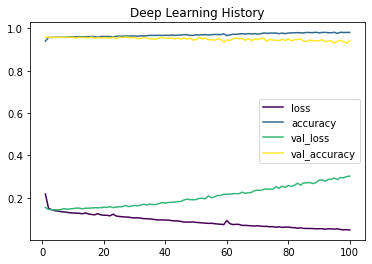

In [37]:
#Plot the history
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")


<AxesSubplot:>

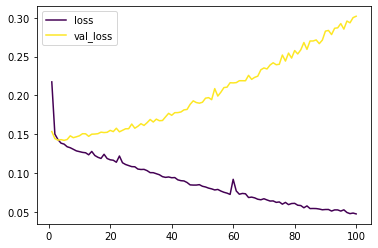

In [38]:
# Plot the loss
deep_history_df.plot(y=["loss", "val_loss"], colormap= "viridis")

<AxesSubplot:>

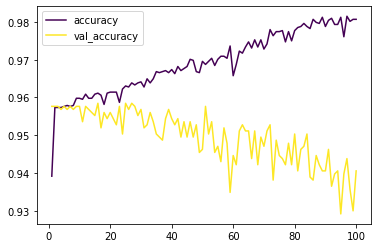

In [39]:
# Plot the accuracy
deep_history_df.plot(y=["accuracy", "val_accuracy"], colormap= "viridis")

In [40]:
# Evaluate the model using the test data
dl_model_loss, dl_model_accuracy = deep_nn_model.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the deep learning model is: {dl_model_loss}, The accuracy is: {dl_model_accuracy}")

 The loss for the deep learning model is: 0.3018311858177185, The accuracy is: 0.9405537247657776


In [41]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_dl = deep_nn_model.predict(X_test_scaled)
y_pred_dl = y_pred_dl.flatten()
y_pred_dl_tf=tf.round(y_pred_dl)

[[   2   50]
 [  23 1153]]


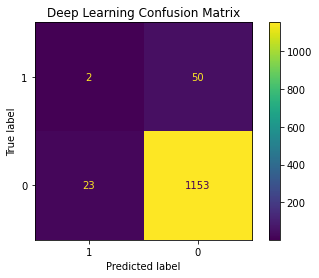

In [42]:
# Display the confusion matrix
dl_nn_cm = confusion_matrix(y_test, y_pred_dl_tf, labels=[1,0])
print (dl_nn_cm)
dl_disp = ConfusionMatrixDisplay(confusion_matrix=dl_nn_cm, display_labels=[1,0])
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [43]:
# Advanced Classification Metrics
# Accuracy
dl_accuracy_score = accuracy_score(y_test, y_pred_dl_tf)
print(f'Accuracy Score of the Deep Learning Model: {dl_accuracy_score}')

## Recall/Sensitivity
dl_recall_score = recall_score(y_test, y_pred_dl_tf)
print(f'Recall Score of the Deep Learning Model: {dl_recall_score}')

# Specificity
dl_specificity_score = 1164 / 1176
print(f'Specifity Score of the Deep Learning Model: {dl_specificity_score}')

# Balanced Accuracy Score
dl_bas = balanced_accuracy_score(y_test, y_pred_dl_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {dl_bas}')

# Precision
dl_precision_score = precision_score(y_test, y_pred_dl_tf)
print(f'Precision Score of the Deep Learning Model: {dl_precision_score}')     
      
# F1 Score
dl_f1_score = f1_score(y_test, y_pred_dl_tf)
print(f'F1 Score Score of the Deep Learning Model: {dl_f1_score}')

# Loss Score
print(f'Loss of the Deep Learning Model: {dl_model_loss}')

# Advanced Classification Metrics DF
dl_acm = {"Model Type": ["Deep Learning"], "Accuracy":[dl_accuracy_score], "Recall": [dl_recall_score], "Specificity":[dl_specificity_score], 
          "Balanced Accuracy": [dl_bas], "Precision":[dl_precision_score], "F1 Score":[dl_f1_score], "Loss": [dl_model_loss]}
dl_acm_df = pd.DataFrame(data=dl_acm)
dl_acm_df

Accuracy Score of the Deep Learning Model: 0.9405537459283387
Recall Score of the Deep Learning Model: 0.038461538461538464
Specifity Score of the Deep Learning Model: 0.9897959183673469
Balanced Accuracy Score of the Multiple Perceptron Model: 0.5094518576661434
Precision Score of the Deep Learning Model: 0.08
F1 Score Score of the Deep Learning Model: 0.05194805194805195
Loss of the Deep Learning Model: 0.3018311858177185


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Deep Learning,0.940554,0.038462,0.989796,0.509452,0.08,0.051948,0.301831


## Comparison of the Models

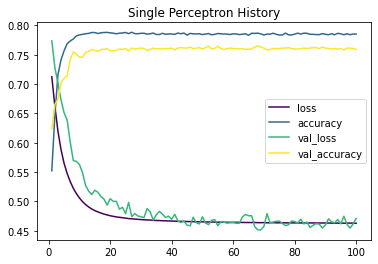

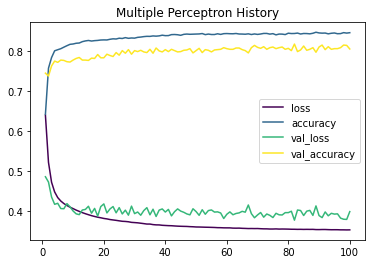

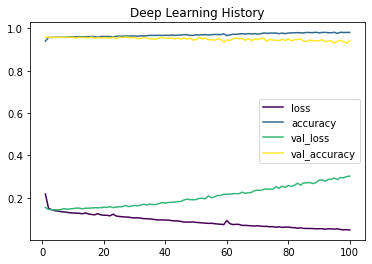

In [44]:
nn_history_plot = nn_history_df.plot(title = "Single Perceptron History",colormap= "viridis")
multi_history_plotf = multi_history_df.plot(title = "Multiple Perceptron History",colormap= "viridis")
deep_history_plot = deep_history_df.plot(title = "Deep Learning History",colormap= "viridis")

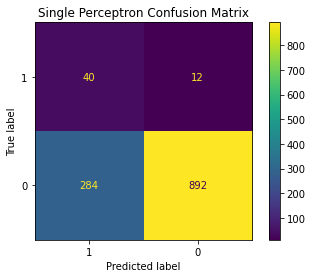

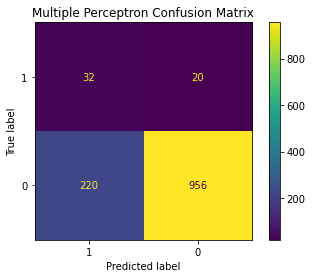

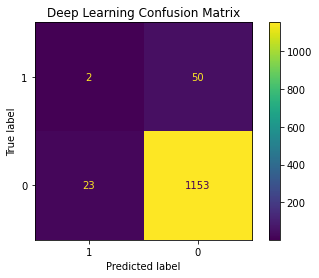

In [45]:
# Single Perceptron Confusion Matrix
nn_disp.plot()
nn_disp.ax_.set_title("Single Perceptron Confusion Matrix")

# Multiple Perceptron Confusion Matrix
multi_disp.plot()
multi_disp.ax_.set_title("Multiple Perceptron Confusion Matrix")

# Deep Learning Confusion Matrix
dl_disp.plot()
dl_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_disp

In [46]:
# Total Advanced Classification Metrics DF
total_acm = ({"Model Type": "Single Perceptron", "Accuracy":nn_accuracy_score, "Recall": nn_recall_score, "Specificity":nn_specificity_score, 
          "Balanced Accuracy": nn_bas, "Precision":nn_precision_score, "F1 Score":nn_f1_score, "Loss": nn_model_loss }, {"Model Type": "Multi Perceptron", "Accuracy":multi_accuracy_score, "Recall": multi_recall_score, "Specificity":multi_specificity_score, 
          "Balanced Accuracy": multi_bas, "Precision":multi_precision_score, "F1 Score":multi_f1_score, "Loss": multi_model_loss}, {"Model Type": "Deep Learning", "Accuracy":dl_accuracy_score, "Recall": dl_recall_score, "Specificity":dl_specificity_score, 
          "Balanced Accuracy": dl_bas, "Precision":dl_precision_score, "F1 Score":dl_f1_score, "Loss": dl_model_loss})
total_acm_df = pd.DataFrame(data=total_acm)
total_acm_df

,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.758958,0.769231,0.715136,0.763867,0.123457,0.212766,0.470768
1,Multi Perceptron,0.804560,0.615385,0.807823,0.714155,0.126984,0.210526,0.398965
2,Deep Learning,0.940554,0.038462,0.989796,0.509452,0.080000,0.051948,0.301831


## 5 Epochs

In [127]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 3000
hidden_nodes_layer2 = 1500
hidden_nodes_layer3 = 800

deep_nn_model_5 = tf.keras.models.Sequential()

# First hidden layer
deep_nn_model_5.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
deep_nn_model_5.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
deep_nn_model_5.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
deep_nn_model_5.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
deep_nn_model_5.summary()


# Compile the model
deep_nn_model_5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 3000)              66000     
                                                                 
 dense_38 (Dense)            (None, 1500)              4501500   
                                                                 
 dense_39 (Dense)            (None, 800)               1200800   
                                                                 
 dense_40 (Dense)            (None, 1)                 801       
                                                                 
Total params: 5,769,101
Trainable params: 5,769,101
Non-trainable params: 0
_________________________________________________________________


In [128]:
# Train the model
fit_model_deep_5 = deep_nn_model_5.fit(X_train_scaled, y_train, validation_data = (X_test_scaled, y_test), epochs=20)

# Create a DataFrame containing training history
deep_history_df_5 = pd.DataFrame(fit_model_deep_5.history, index=range(1,len(fit_model_deep_5.history["loss"])+1))

Epoch 1/20
116/116 [==============================] - 13s 98ms/step - loss: 0.1818 - accuracy: 0.9503 - val_loss: 0.2053 - val_accuracy: 0.9577
Epoch 2/20
116/116 [==============================] - 8s 70ms/step - loss: 0.1595 - accuracy: 0.9573 - val_loss: 0.1451 - val_accuracy: 0.9577
Epoch 3/20
116/116 [==============================] - 8s 71ms/step - loss: 0.1458 - accuracy: 0.9573 - val_loss: 0.1503 - val_accuracy: 0.9577
Epoch 4/20
116/116 [==============================] - 8s 65ms/step - loss: 0.1418 - accuracy: 0.9573 - val_loss: 0.1439 - val_accuracy: 0.9577
Epoch 5/20
116/116 [==============================] - 8s 66ms/step - loss: 0.1362 - accuracy: 0.9579 - val_loss: 0.1616 - val_accuracy: 0.9577
Epoch 6/20
116/116 [==============================] - 6s 55ms/step - loss: 0.1363 - accuracy: 0.9573 - val_loss: 0.1533 - val_accuracy: 0.9585
Epoch 7/20
116/116 [==============================] - 7s 58ms/step - loss: 0.1369 - accuracy: 0.9571 - val_loss: 0.1488 - val_accuracy: 0.958

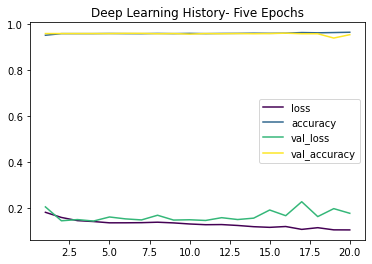

In [129]:
#Plot the history
deep_history_plot_5 = deep_history_df_5.plot(title = "Deep Learning History- Five Epochs",colormap= "viridis")

In [130]:
# Evaluate the model using the test data
dl_model_5_loss, dl_model_5_accuracy = deep_nn_model_5.evaluate(X_test_scaled,y_test,verbose=0)
print(f" The loss for the deep learning model is: {dl_model_loss}, The accuracy is: {dl_model_accuracy}")

 The loss for the deep learning model is: 0.3018311858177185, The accuracy is: 0.9405537247657776


tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(1228,), dtype=float32)


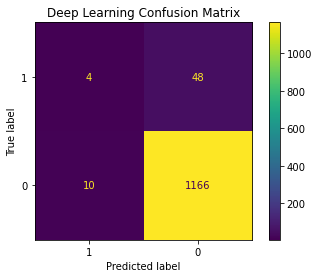

In [131]:
#Y_pred: flatten & Convert prediction probabilities to binary format
y_pred_dl_5 = deep_nn_model_5.predict(X_test_scaled)
y_pred_dl_5 = y_pred_dl_5.flatten()
y_pred_dl_5_tf=tf.round(y_pred_dl_5)

# Display the confusion matrix
dl_5_nn_cm = confusion_matrix(y_test, y_pred_dl_5_tf, labels=[1,0])
print (y_pred_dl_5_tf)
dl_5_disp = ConfusionMatrixDisplay(confusion_matrix=dl_5_nn_cm, display_labels=[1,0])
dl_5_disp.plot()
dl_5_disp.ax_.set_title("Deep Learning Confusion Matrix")
dl_5_disp

In [132]:
# Advanced Classification Metrics
# Accuracy
dl_5_accuracy_score = accuracy_score(y_test, y_pred_dl_5_tf)
print(f'Accuracy Score of the Deep Learning Model: {dl_5_accuracy_score}')

## Recall/Sensitivity
dl_5_recall_score = recall_score(y_test, y_pred_dl_5_tf)
print(f'Recall Score of the Deep Learning Model: {dl_5_recall_score}')

# Specificity
dl_5_specificity_score = 1164 / 1176
print(f'Specifity Score of the Deep Learning Model: {dl_5_specificity_score}')

# Balanced Accuracy Score
dl_5_bas = balanced_accuracy_score(y_test, y_pred_dl_5_tf)
print(f'Balanced Accuracy Score of the Multiple Perceptron Model: {dl_5_bas}')

# Precision
dl_5_precision_score = precision_score(y_test, y_pred_dl_5_tf)
print(f'Precision Score of the Deep Learning Model: {dl_5_precision_score}')     
      
# F1 Score
dl_5_f1_score = f1_score(y_test, y_pred_dl_5_tf)
print(f'F1 Score Score of the Deep Learning Model: {dl_5_f1_score}')

# Loss Score
print(f'Loss of the Deep Learning Model: {dl_model_5_loss}')

# Advanced Classification Metrics DF
dl_5_acm = {"Model Type": ["Deep Learning- 5 Epochs"], "Accuracy":[dl_5_accuracy_score], "Recall": [dl_5_recall_score], "Specificity":[dl_5_specificity_score], 
          "Balanced Accuracy": [dl_5_bas], "Precision":[dl_5_precision_score], "F1 Score":[dl_5_f1_score], "Loss": [dl_model_5_loss]}
dl_5_acm_df = pd.DataFrame(data=dl_5_acm)
dl_5_acm_df

Accuracy Score of the Deep Learning Model: 0.9527687296416938
Recall Score of the Deep Learning Model: 0.07692307692307693
Specifity Score of the Deep Learning Model: 0.9897959183673469
Balanced Accuracy Score of the Multiple Perceptron Model: 0.5342098377812664
Precision Score of the Deep Learning Model: 0.2857142857142857
F1 Score Score of the Deep Learning Model: 0.12121212121212123
Loss of the Deep Learning Model: 0.17756937444210052


,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Deep Learning- 5 Epochs,0.952769,0.076923,0.989796,0.53421,0.285714,0.121212,0.177569


In [134]:
# Total Advanced Classification Metrics DF
total_acm_5 = ({"Model Type": "Single Perceptron", "Accuracy":nn_accuracy_score, "Recall": nn_recall_score, "Specificity":nn_specificity_score, 
          "Balanced Accuracy": nn_bas, "Precision":nn_precision_score, "F1 Score":nn_f1_score, "Loss": nn_model_loss }, {"Model Type": "Multi Perceptron", "Accuracy":multi_accuracy_score, "Recall": multi_recall_score, "Specificity":multi_specificity_score, 
          "Balanced Accuracy": multi_bas, "Precision":multi_precision_score, "F1 Score":multi_f1_score, "Loss": multi_model_loss}, {"Model Type": "Deep Learning", "Accuracy":dl_accuracy_score, "Recall": dl_recall_score, "Specificity":dl_specificity_score, 
          "Balanced Accuracy": dl_bas, "Precision":dl_precision_score, "F1 Score":dl_f1_score, "Loss": dl_model_loss}, {"Model Type": "Deep Learning- 5 Epochs", "Accuracy":dl_5_accuracy_score, "Recall": dl_5_recall_score, "Specificity":dl_5_specificity_score, 
          "Balanced Accuracy": dl_5_bas, "Precision":dl_5_precision_score, "F1 Score":dl_5_f1_score, "Loss": dl_model_5_loss})
total_acm_5_df = pd.DataFrame(data=total_acm_5)
total_acm_5_df

,Model Type,Accuracy,Recall,Specificity,Balanced Accuracy,Precision,F1 Score,Loss
0,Single Perceptron,0.758958,0.769231,0.715136,0.763867,0.123457,0.212766,0.470768
1,Multi Perceptron,0.804560,0.615385,0.807823,0.714155,0.126984,0.210526,0.398965
2,Deep Learning,0.940554,0.038462,0.989796,0.509452,0.080000,0.051948,0.301831
3,Deep Learning- 5 Epochs,0.952769,0.076923,0.989796,0.534210,0.285714,0.121212,0.177569
